In [4]:
import numpy as np
import pandas as pd
import os
import json # for reading annotations from json
from tqdm.auto import tqdm
import random
from PIL import Image,ImageDraw
import tensorflow as tf
from collections import Counter 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay

# import h5py
!pip install torchsummary
from torchsummary import summary

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
import glob
path="/kaggle/input/diabetic-retinopathy-dataset/"

In [7]:
healthy=glob.glob(path+'Healthy/*.png')
mild=glob.glob(path+'Mild DR/*.png')
moderate=glob.glob(path+'Moderate DR/*.png')
proliferate=glob.glob(path+'Proliferate DR/*.png')
severe=glob.glob(path+'Severe DR/*.png')
images_t=healthy+mild+moderate+proliferate+severe
labels=np.zeros(len(images_t),dtype=np.int32)
labels[:len(healthy)]=0
labels[len(healthy):len(healthy)+len(mild)]=1
labels[len(healthy)+len(mild):len(healthy)+len(mild)+len(moderate)]=2
labels[len(healthy)+len(mild)+len(moderate):len(healthy)+len(mild)+len(moderate)+len(proliferate)]=3
labels[len(healthy)+len(mild)+len(moderate)+len(proliferate):]=4

In [8]:
img_h=256
img_w=256

In [9]:
class CustDat(torch.utils.data.Dataset):  
    def __init__(self, images, labels, indices, transform=None):
        self.labels = labels
        self.images = images
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices) * 2  # Double the length to include augmented images
        
    def __getitem__(self, idx):
        original_idx = idx // 2  # Get the original index

        image_path = self.images[self.indices[original_idx]]
        img = Image.open(image_path).convert('L').resize((img_h, img_w))
        
        label = self.labels[self.indices[original_idx]]
        labs = torch.zeros(5, dtype=torch.float64)
        labs[label] = 1
        
        if idx % 2 == 1 and self.transform:  # Apply augmentation to odd indices
            img = self.transform(img)
        else:
            img=T.ToTensor()(img)
        return img, labs

In [10]:
data_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
])

In [11]:
unique_imgs=range(len(images_t))
#since getitem is based on index
train_idx,val_idx=train_test_split(unique_imgs,test_size=0.2,random_state=442)

In [12]:
# def custom_collate(data):
#     return data
train_dl=torch.utils.data.DataLoader(
                CustDat(images_t, labels, train_idx, transform=data_transforms),
                batch_size=16,
                shuffle=True,
#                 collate_fn=custom_collate,
                pin_memory=True if torch.cuda.is_available() else False
            )
val_dl=torch.utils.data.DataLoader(
                CustDat(images_t, labels, val_idx, transform=T.ToTensor()),
                batch_size=16,
                shuffle=True,
#                 collate_fn=custom_collate,
                pin_memory=True if torch.cuda.is_available() else False
            )

In [13]:
len(val_dl)

69

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DenseNetCustom(nn.Module):
    def __init__(self):
        super(DenseNetCustom, self).__init__()
        # Load pre-trained DenseNet121 model
        densenet_model = models.densenet121(pretrained=True)

        # Modify the first convolutional layer to accept one input channel
        densenet_model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        densenet_model.classifier = nn.Linear(1024, 5)
        self.model = densenet_model
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Change according to your needs
        self.output = nn.Softmax(dim=1)

        # Freezing layers
        self.freeze_layers()

    def freeze_layers(self):
        # Specify the layers to be frozen
        layers_to_freeze = [self.model.features.denseblock1, self.model.features.transition1,
                             self.model.features.denseblock2, self.model.features.transition2,
                             self.model.features.denseblock3, self.model.features.transition3,
                             self.model.features.denseblock4, self.model.features.norm5]

        # Freeze the specified layers
        for layer in layers_to_freeze:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x

# Creating an instance of the DenseNet model
model = DenseNetCustom().to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# model.eval()

In [25]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)#,weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold_mode='abs', threshold=0.01, min_lr=1e-8)
criterion=nn.CrossEntropyLoss()#.to(torch.float)  categoricalcrossentropy yeilds same result
num_epochs=50

In [26]:
def Train():
    model.train()
# for epochs in range(num_epochs):   # number of epochs
#     print(f'-----Running epoch[{epochs+1}]-----')
    epoch_loss=0
    precision=[]
    recall=[]
    for _,data in tqdm(enumerate(train_dl),total=len(train_dl)):    #iterating over batches
        
        imgs=[]
        targets=[]
        
        for d in data[0]:
            imgs.append(d.to(device))
        for d in data[1]:
            targets.append(d.to(device))
        
        
        imgs=torch.stack(imgs,dim=0)
        targets=torch.stack(targets,dim=0)
        pred=model(imgs).to(torch.float64)
        loss=criterion(pred,targets)
        # Optionally apply weighting to loss components
        epoch_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(pred,1)
        _, targs=torch.max(targets,1)
        prec = precision_score(targs.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted',zero_division=1)
        rec = recall_score(targs.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted',zero_division=1)
        precision.append(prec)
        recall.append(rec)
    
    print(f'epoch [{epochs+1}] loss:',epoch_loss.item(),'Train Accuracy:',100-epoch_loss.item()*100/(len(train_dl)*16),'Precision:',np.mean(precision),'Recall:',np.mean(recall))
    scheduler.step(epoch_loss)
    return epoch_loss.item(),100-epoch_loss.item()*100/(len(train_dl)*16),np.mean(precision),np.mean(recall)

In [27]:
def Eval():
    model.eval()
    overall_loss=0
    test=[]
    pred_res=[]
    val_loss=[]
    precision=[]
    recall=[]
    for data in val_dl:    #iterating over batches

        imgs=[]
        targets=[]

        for d in data[0]:
            imgs.append(d.to(device))
        for d in data[1]:
            targets.append(d.to(device))


        imgs=torch.stack(imgs,dim=0)
        targets=torch.stack(targets,dim=0)
        pred=model(imgs).to(torch.float64)
#         print(targets.shape,pred.shape)
        loss=criterion(pred,targets).detach().cpu()
        # Optionally apply weighting to loss components
        overall_loss+=loss

        #calculating other parameters such as precision,recall
        _, predicted = torch.max(pred,1)
        _, targs=torch.max(targets,1)
        prec = precision_score(targs.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted',zero_division=1)
        rec = recall_score(targs.detach().cpu().numpy(), predicted.detach().cpu().numpy(), average='weighted',zero_division=1)
        precision.append(prec)
        recall.append(rec)
    print('Validation Accuracy:',100-overall_loss.item()*100/(len(val_dl)*16))
    
    
    return overall_loss.item(),100-overall_loss.item()*100/(len(val_dl)*16),np.mean(precision),np.mean(recall)
#     return test,pred_res

In [28]:
# summary(model,input_size=(3,256,256))

In [29]:
Eval()

Validation Accuracy: 91.63891928083437


(92.30633113958848, 91.63891928083437, 0.7919285650943259, 0.6292270531400966)

In [30]:
train_acc=[]
train_loss=[]
train_precision=[]
train_recall=[]
val_acc=[]
val_loss=[]
val_precision=[]
val_recall=[]
for epochs in range(num_epochs):   # number of epochs
    print(f'-----Running epoch[{epochs+1}]-----')
    t_loss,t_acc,t_p,t_r=Train()
    train_loss.append(t_loss)
    train_acc.append(t_acc)
    train_precision.append(t_p)
    train_recall.append(t_r)
    v_loss,v_acc,v_p,v_r=Eval()
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    val_precision.append(v_p)
    val_recall.append(v_r)

-----Running epoch[1]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [1] loss: 368.95321738526167 Train Accuracy: 91.61469960488041 Precision: 0.7939831803297712 Recall: 0.5986363636363636
Validation Accuracy: 92.00534240036676
-----Running epoch[2]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [2] loss: 361.6314572566958 Train Accuracy: 91.781103244166 Precision: 0.7993818265068265 Recall: 0.6052272727272727
Validation Accuracy: 92.06267454080653
-----Running epoch[3]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [3] loss: 358.7645120408065 Train Accuracy: 91.84626108998167 Precision: 0.8025194445705809 Recall: 0.6084090909090909
Validation Accuracy: 92.15725045354917
-----Running epoch[4]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [4] loss: 357.0655891218226 Train Accuracy: 91.88487297450403 Precision: 0.804047928082019 Recall: 0.6147727272727272
Validation Accuracy: 92.1901606089369
-----Running epoch[5]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [5] loss: 355.13602145627954 Train Accuracy: 91.92872678508455 Precision: 0.8036116692650784 Recall: 0.62
Validation Accuracy: 92.21335303969208
-----Running epoch[6]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [6] loss: 354.4881763881187 Train Accuracy: 91.94345053663366 Precision: 0.8078194375069374 Recall: 0.6272727272727273
Validation Accuracy: 92.22402218094449
-----Running epoch[7]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [7] loss: 353.4082046332966 Train Accuracy: 91.96799534924327 Precision: 0.8017860863883591 Recall: 0.625
Validation Accuracy: 92.24859335120202
-----Running epoch[8]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [8] loss: 352.54966510589213 Train Accuracy: 91.98750761122972 Precision: 0.8100509049031777 Recall: 0.6306818181818182
Validation Accuracy: 92.23144685660999
-----Running epoch[9]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [9] loss: 352.0317468705749 Train Accuracy: 91.9992784802142 Precision: 0.8069858336108336 Recall: 0.6325
Validation Accuracy: 92.23011698692704
-----Running epoch[10]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [10] loss: 351.26796707127835 Train Accuracy: 92.0166371120164 Precision: 0.8102501652388016 Recall: 0.6343181818181818
Validation Accuracy: 92.24505650240413
-----Running epoch[11]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [11] loss: 350.7606364893166 Train Accuracy: 92.02816735251554 Precision: 0.8082489612660066 Recall: 0.635
Validation Accuracy: 92.28516859634504
-----Running epoch[12]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [12] loss: 350.56153000255955 Train Accuracy: 92.03269249994183 Precision: 0.8126438889393435 Recall: 0.6388636363636364
Validation Accuracy: 92.29189843529844
-----Running epoch[13]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [13] loss: 350.3615557532236 Train Accuracy: 92.03723736924492 Precision: 0.8108760759442577 Recall: 0.6356818181818182
Validation Accuracy: 92.29892849318986
-----Running epoch[14]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [14] loss: 349.9213263080957 Train Accuracy: 92.04724258390692 Precision: 0.8121454410488501 Recall: 0.6375
Validation Accuracy: 92.31838717314484
-----Running epoch[15]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [15] loss: 349.2102571573099 Train Accuracy: 92.06340324642477 Precision: 0.8124317885397432 Recall: 0.6404545454545455
Validation Accuracy: 92.33249106446993
-----Running epoch[16]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [16] loss: 346.07994995590605 Train Accuracy: 92.13454659191123 Precision: 0.8004007356280084 Recall: 0.6513636363636364
Validation Accuracy: 92.35003013022092
-----Running epoch[17]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [17] loss: 343.5160742658444 Train Accuracy: 92.19281649395808 Precision: 0.784919085333858 Recall: 0.6627272727272727
Validation Accuracy: 92.38721414145684
-----Running epoch[18]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [18] loss: 342.57648989147174 Train Accuracy: 92.21417068428474 Precision: 0.7845151925095106 Recall: 0.6640909090909091
Validation Accuracy: 92.4165174304695
-----Running epoch[19]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [19] loss: 341.49983569553655 Train Accuracy: 92.23864009782872 Precision: 0.782267963728191 Recall: 0.6679545454545455
Validation Accuracy: 92.41519317880783
-----Running epoch[20]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [20] loss: 339.83650851459004 Train Accuracy: 92.27644298830478 Precision: 0.7944414934812661 Recall: 0.6793181818181818
Validation Accuracy: 92.40262235821805
-----Running epoch[21]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [21] loss: 340.93572473290567 Train Accuracy: 92.25146080152487 Precision: 0.7814877344877346 Recall: 0.6704545454545454
Validation Accuracy: 92.4231986001322
-----Running epoch[22]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [22] loss: 340.38015496222823 Train Accuracy: 92.26408738722209 Precision: 0.7843849616292798 Recall: 0.6747727272727273
Validation Accuracy: 92.36534018807676
-----Running epoch[23]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [23] loss: 339.8417901108666 Train Accuracy: 92.27632295202577 Precision: 0.7837747687918143 Recall: 0.6738636363636363
Validation Accuracy: 92.41707602743591
-----Running epoch[24]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [24] loss: 339.19926864140416 Train Accuracy: 92.29092571269535 Precision: 0.7879414190607372 Recall: 0.6768181818181818
Validation Accuracy: 92.42996280714179
-----Running epoch[25]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [25] loss: 338.8540607528055 Train Accuracy: 92.29877134652715 Precision: 0.7884550127902402 Recall: 0.6779545454545455
Validation Accuracy: 92.43785347161034
-----Running epoch[26]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [26] loss: 338.3751648963418 Train Accuracy: 92.30965534326496 Precision: 0.7868754919323101 Recall: 0.6809090909090909
Validation Accuracy: 92.45130270287635
-----Running epoch[27]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [27] loss: 337.7073585176611 Train Accuracy: 92.32483276096225 Precision: 0.784905606388561 Recall: 0.6829545454545455
Validation Accuracy: 92.45475959907532
-----Running epoch[28]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [28] loss: 336.3533158768163 Train Accuracy: 92.35560645734509 Precision: 0.7935692476715204 Recall: 0.6888636363636363
Validation Accuracy: 92.37879626130061
-----Running epoch[29]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [29] loss: 337.65108080993053 Train Accuracy: 92.32611179977431 Precision: 0.7905150941230487 Recall: 0.6825
Validation Accuracy: 92.45702658693078
-----Running epoch[30]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [30] loss: 337.50624160742336 Train Accuracy: 92.32940359983128 Precision: 0.7958914305391578 Recall: 0.6845454545454546
Validation Accuracy: 92.45620488241376
-----Running epoch[31]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [31] loss: 336.42699657275045 Train Accuracy: 92.35393189607386 Precision: 0.7939207743014561 Recall: 0.6863636363636364
Validation Accuracy: 92.46342980075967
-----Running epoch[32]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [32] loss: 335.22833089118956 Train Accuracy: 92.38117429792752 Precision: 0.7922785812672176 Recall: 0.6909090909090909
Validation Accuracy: 92.44389732050347
-----Running epoch[33]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [33] loss: 338.0379210710448 Train Accuracy: 92.31731997565807 Precision: 0.794155204643841 Recall: 0.6804545454545454
Validation Accuracy: 92.48281646945594
-----Running epoch[34]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [34] loss: 335.1993868491966 Train Accuracy: 92.38183211706371 Precision: 0.7954809294241113 Recall: 0.6920454545454545
Validation Accuracy: 92.50335397296801
-----Running epoch[35]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [35] loss: 335.80910438064257 Train Accuracy: 92.36797490043995 Precision: 0.7932233372687918 Recall: 0.6897727272727273
Validation Accuracy: 92.47270108079142
-----Running epoch[36]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [36] loss: 335.7012821487787 Train Accuracy: 92.37042540570957 Precision: 0.8016022727272728 Recall: 0.6902272727272727
Validation Accuracy: 92.50564494137652
-----Running epoch[37]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [37] loss: 334.29585871941765 Train Accuracy: 92.40236684728596 Precision: 0.8020834153220516 Recall: 0.695
Validation Accuracy: 92.45531453259522
-----Running epoch[38]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [38] loss: 334.3612450513312 Train Accuracy: 92.40088079428793 Precision: 0.7979881936245573 Recall: 0.6943181818181818
Validation Accuracy: 92.5182717875479
-----Running epoch[39]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [39] loss: 333.8705443022543 Train Accuracy: 92.41203308403968 Precision: 0.7916157762691853 Recall: 0.6947727272727273
Validation Accuracy: 92.48248889772347
-----Running epoch[40]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [40] loss: 334.78326934656786 Train Accuracy: 92.39128933303255 Precision: 0.7950294339498885 Recall: 0.6904545454545454
Validation Accuracy: 92.45058292234975
-----Running epoch[41]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [41] loss: 334.187145508637 Train Accuracy: 92.40483760207643 Precision: 0.802269906860816 Recall: 0.6954545454545454
Validation Accuracy: 92.52831408088102
-----Running epoch[42]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [42] loss: 334.5149695903963 Train Accuracy: 92.39738705476373 Precision: 0.7997089728453365 Recall: 0.6915909090909091
Validation Accuracy: 92.51398300155907
-----Running epoch[43]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [43] loss: 333.9448698826911 Train Accuracy: 92.41034386630247 Precision: 0.8017769988849535 Recall: 0.6940909090909091
Epoch 00043: reducing learning rate of group 0 to 5.0000e-05.
Validation Accuracy: 92.4763747004927
-----Running epoch[44]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [44] loss: 333.287331061474 Train Accuracy: 92.42528793042105 Precision: 0.7987473599632691 Recall: 0.6963636363636364
Validation Accuracy: 92.51560380155745
-----Running epoch[45]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [45] loss: 332.44190791906715 Train Accuracy: 92.44450209274848 Precision: 0.8029490440115441 Recall: 0.7013636363636364
Validation Accuracy: 92.52051327255056
-----Running epoch[46]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [46] loss: 332.80486118657416 Train Accuracy: 92.43625315485059 Precision: 0.8025629181424636 Recall: 0.7013636363636364
Validation Accuracy: 92.52242991888436
-----Running epoch[47]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [47] loss: 334.3571695293625 Train Accuracy: 92.40097341978722 Precision: 0.7978032844680572 Recall: 0.6936363636363636
Validation Accuracy: 92.49030252580512
-----Running epoch[48]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [48] loss: 332.24064869999256 Train Accuracy: 92.44907616590926 Precision: 0.8065705266955266 Recall: 0.7045454545454546
Validation Accuracy: 92.47266767019754
-----Running epoch[49]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [49] loss: 333.3784833394122 Train Accuracy: 92.42321628774063 Precision: 0.8051574757313393 Recall: 0.6975
Validation Accuracy: 92.50051285642436
-----Running epoch[50]-----


  0%|          | 0/275 [00:00<?, ?it/s]

epoch [50] loss: 333.11727291389553 Train Accuracy: 92.42915288832056 Precision: 0.8001151285583104 Recall: 0.6959090909090909
Validation Accuracy: 92.51933608932742


In [31]:
# torch.save(model.state_dict(), 'model_weights.pth')

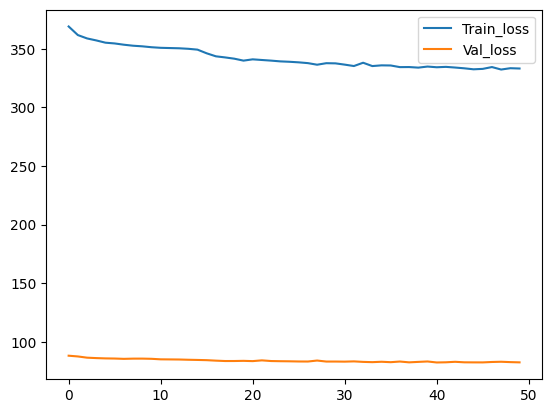

In [32]:
plt.plot(train_loss,label='Train_loss')
plt.plot(val_loss,label='Val_loss')
plt.legend(loc='upper right')

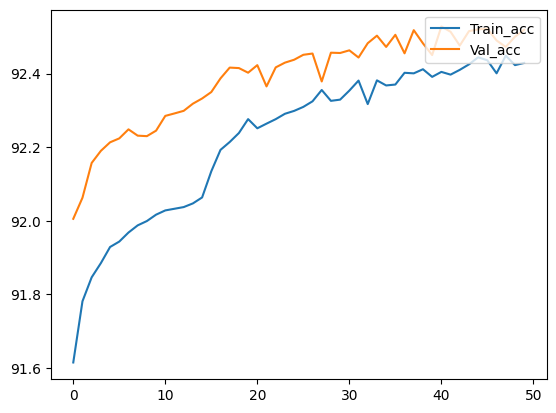

In [33]:
plt.plot(train_acc,label='Train_acc')
plt.plot(val_acc,label='Val_acc')
plt.legend(loc='upper right')

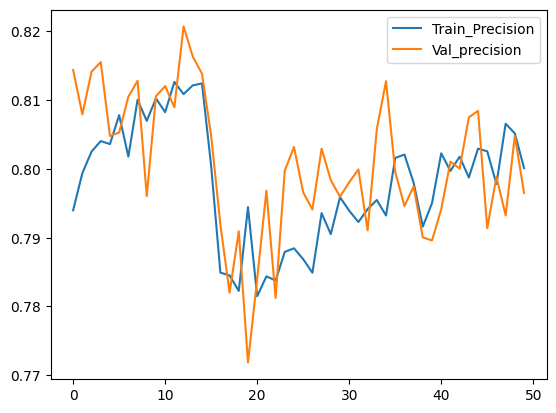

In [34]:
plt.plot(train_precision,label='Train_Precision')
plt.plot(val_precision,label='Val_precision')
plt.legend(loc='upper right')

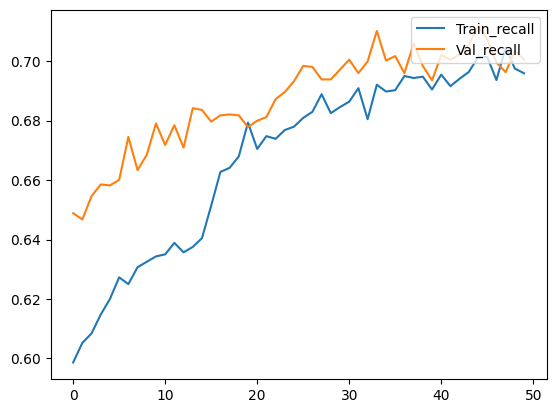

In [35]:
plt.plot(train_recall,label='Train_recall')
plt.plot(val_recall,label='Val_recall')
plt.legend(loc='upper right')

In [36]:
data_iter=iter(val_dl)
data=next(data_iter)
predicted=torch.tensor([])
real=torch.tensor([])

for data in train_dl:
    imgs=[]
    targets=[]
    for d in data[0]:
        imgs.append(d.to(device))
    for d in data[1]:
        targets.append(d.to(device))
    
    
    
    imgs=torch.stack(imgs,dim=0)
    targets=torch.stack(targets,dim=0)
    pred=model(imgs).to(torch.float64)
    _,pred=torch.max(pred,1)
    _,r=torch.max(targets,1)
    predicted=torch.cat((predicted,pred.detach().cpu()))
    real=torch.cat((real,r.detach().cpu()))

In [37]:
conf_matrix = confusion_matrix(predicted.detach().cpu(), real.detach().cpu())

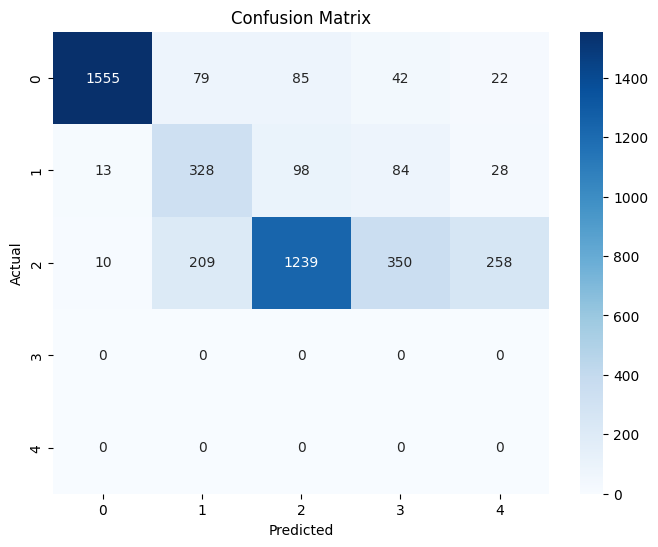

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()